In [1]:
# Uncomment to use autoreload
%load_ext autoreload
%autoreload 2

import os
import os.path as osp
import sys
import torch
import numpy as np
from time import time
from omegaconf import OmegaConf
start = time()
import warnings
warnings.filterwarnings('ignore')

# torch.cuda.set_device(I_GPU)
DIR = os.path.dirname(os.getcwd())
ROOT = os.path.join(DIR, "..")
sys.path.insert(0, ROOT)
sys.path.insert(0, DIR)

from torch_points3d.utils.config import hydra_read
from torch_geometric.data import Data
from torch_points3d.core.multimodal.data import MMData, MMBatch
from torch_points3d.visualization.multimodal_data import visualize_mm_data
from torch_points3d.core.multimodal.image import SameSettingImageData, ImageData
from torch_points3d.datasets.segmentation.multimodal.scannet import ScannetDatasetMM
from torch_points3d.datasets.segmentation.scannet import CLASS_COLORS, CLASS_NAMES, CLASS_LABELS
from torch_points3d.metrics.segmentation_tracker import SegmentationTracker
from torch_points3d.datasets.segmentation import IGNORE_LABEL
from torch_points3d.metrics.scannet_segmentation_tracker import ScannetSegmentationTracker
from torch_points3d.metrics.colored_tqdm import Coloredtqdm as Ctq


from PIL import Image

import matplotlib.pyplot as plt 

%matplotlib inline

CLASS_COLORS[0] = (174.0, 199.0, 232.0)
CLASS_COLORS[-1] = (0, 0, 0)
import plotly.io as pio

#pio.renderers.default = 'jupyterlab'        # for local notebook
pio.renderers.default = 'iframe_connected'  # for remote notebook. Other working (but seemingly slower) options are: 'sphinx_gallery' and 'iframe'

MMData debug() function changed, please uncomment the 3rd assert line when doing inference without M2F features!


In [2]:
# Functions for evaluation

def get_seen_points(mm_data, return_mask=False):
    ### Select seen points
    csr_idx = mm_data.modalities['image'][0].view_csr_indexing
    
    seen_mask = (csr_idx[1:] > csr_idx[:-1])
    if return_mask:
        return mm_data[seen_mask], seen_mask
    else:
        return mm_data[seen_mask]

def get_mode_pred(data):
    pixel_validity = data.data.mvfusion_input[:, :, 0].bool()
    mv_preds = data.data.mvfusion_input[:, :, -1].long()
            
    valid_m2f_feats = []
    for i in range(len(mv_preds)):
        valid_m2f_feats.append(mv_preds[i][pixel_validity[i]])

    mode_preds = []
    for m2feats_of_seen_point in valid_m2f_feats:
        mode_preds.append(torch.mode(m2feats_of_seen_point.squeeze(), dim=0)[0])
    mode_preds = torch.stack(mode_preds, dim=0)
        
    return mode_preds

def get_normalized_entropy(labels):
    counts = torch.unique(labels, return_counts=True)[1]
    
    pk = counts / counts.sum()
    len_pk = torch.tensor(len(pk))
    if len_pk == 1:
        normalized_entropy = 0.
    else:
        normalized_entropy = -sum(pk * torch.log2(pk)) / torch.log2(len_pk)
    return normalized_entropy
        
def get_semantic_image_from_camera(dataset, scene, mesh_triangles, intrinsic, extrinsic, class_id_faces, im_size=(480, 640)):
    """
    Returns the back-projected semantic label image given camera parameters and (semantic) mesh.
    """
    
    # Initialize rays for given camera
    rays = o3d.t.geometry.RaycastingScene.create_rays_pinhole(
        intrinsic_matrix=intrinsic,
        extrinsic_matrix=extrinsic,
        width_px=im_size[1],
        height_px=im_size[0],
    )

    # Get result
    ans = scene.cast_rays(rays)

    primitive_ids = ans['primitive_ids'].numpy()
    primitive_uvs = ans['primitive_uvs'].numpy()

    # Select the closest vertex for each valid face in the projected mesh
    valid_mask = primitive_ids != scene.INVALID_ID

    # https://stackoverflow.com/questions/45212949/vertex-of-a-3d-triangle-that-is-closest-to-a-point-given-barycentric-parameter-o
    w_coords = (1 - primitive_uvs[:, :, 0][valid_mask] - primitive_uvs[:, :, 1][valid_mask])
    barycentric_coords = np.concatenate((w_coords[:, None], primitive_uvs[valid_mask]), axis=-1)

    selected_vertex_idx = np.argmax(barycentric_coords, axis=-1)

    contained_mesh_triangles = mesh_triangles[primitive_ids[valid_mask]]
    closest_mesh_vertices = contained_mesh_triangles[range(len(barycentric_coords)), selected_vertex_idx]
    
    # Map mesh vertices to semantic label
    labels = class_id_faces[closest_mesh_vertices]
    # Remap to [0 ; num_labels - 1]
    labels = dataset.val_dataset._remap_labels(torch.tensor(labels))

    # Visualize back-projection
    image = torch.ones(im_size, dtype=torch.long) * -1
    image[valid_mask] = labels


    # NN interpolation at invalid pixels          
    nearest_neighbor = scipy.ndimage.morphology.distance_transform_edt(
        image==-1, return_distances=False, return_indices=True)    

    image = image[nearest_neighbor].numpy()
    return image

def read_axis_align_matrix(filename):
    try:
        lines = open(filename).readlines()
        axis_align_matrix = None
        for line in lines:
            if "axisAlignment" in line:
                axis_align_matrix = torch.Tensor([float(x) for x in line.rstrip().strip("axisAlignment = ").split(" ")]).reshape((4, 4))
                break
    except:
        print("Cannot find axis align matrix")
        axis_align_matrix = None
    return axis_align_matrix

def save_semantic_prediction_as_txt(tracker, model_name, mask_name):
    orginal_class_ids = np.asarray(tracker._dataset.train_dataset.valid_class_idx)
    path_to_submission = tracker._dataset.path_to_submission
    
    path_to_submission = osp.join(path_to_submission, model_name, mask_name)
    if not osp.exists(path_to_submission):
        os.makedirs(path_to_submission)
    
    for scan_id in tracker._full_preds:
        full_pred = tracker._full_preds[scan_id].cpu().numpy().astype(np.int8)
        full_pred = orginal_class_ids[full_pred]  # remap labels to original labels between 0 and 40
        scan_name = tracker._raw_datas[scan_id].scan_name
        path_file = osp.join(path_to_submission, "{}.txt".format(scan_name))
        
        np.savetxt(path_file, full_pred, delimiter="/n", fmt="%d")
        
    return path_to_submission
        
        


In [3]:
### Note: set over to Python file with argparse from script file
MASK_NAME = 'ViT_masks'


# # DeepSet - DeepSetAttention (check model/config correctness)
checkpoint_dir = '/home/fsun/DeepViewAgg/outputs/2023-02-11/10-52-09'   # ViT_masks
# checkpoint_dir = '/home/fsun/DeepViewAgg/outputs/2023-02-11/10-54-19'   # m2f_masks
dataset_config = 'segmentation/multimodal/Feng/scannet-neucon-smallres-m2f-allviews.yaml'   
models_config = 'segmentation/multimodal/Feng/view_selection_experiment'    # model family
model_name = 'DeepSetAttention'                       # specific model



# # # Transformer - MVFusion_orig
# checkpoint_dir = '/home/fsun/DeepViewAgg/outputs/MVFusion_orig'   # ViT_masks
# # checkpoint_dir = '/home/fsun/DeepViewAgg_31-10-22/DeepViewAgg/outputs/2023-02-11/22-17-12'   # m2f_masks
# dataset_config = 'segmentation/multimodal/Feng/scannet-neucon-smallres-m2f-allviews.yaml'   
# models_config = 'segmentation/multimodal/Feng/mvfusion_orig'    # model family
# model_name = 'MVFusion_orig'                       # specific model

overrides = [
    'task=segmentation',
    f'data={dataset_config}',
    f'data.dataroot=/scratch-shared/fsun/dvata',
    f'models={models_config}',
    f'model_name={model_name}',
]

cfg = hydra_read(overrides)
OmegaConf.set_struct(cfg, False)  # This allows getattr and hasattr methods to function correctly
cfg.data.load_m2f_masks = True   # load input masks
cfg.data.m2f_preds_dirname = MASK_NAME
cfg.data.n_views = cfg.models[model_name].backbone.transformer.n_views
print(cfg.data.n_views)

# Dataset instantiation
start = time()
dataset = ScannetDatasetMM(cfg.data)
print(f"Dataset Creation Time = {time() - start:0.1f} sec.")



6
Load predicted 2D semantic segmentation labels from directory  ViT_masks
initialize train dataset
initialize val dataset
Dataset Creation Time = 7.6 sec.


In [4]:
from torch_points3d.models.model_factory import instantiate_model

# Set your parameters
# checkpoint_dir = '/home/fsun/DeepViewAgg/outputs/2022-12-07/12-07-34' # 3rd run
# checkpoint_dir = '/home/fsun/DeepViewAgg/outputs/ViT_masks_3rd_run'

# Create the model
print(f"Creating model: {cfg.model_name}")
model = instantiate_model(cfg, dataset)

# Load the checkpoint and recover the model weights
checkpoint = torch.load(f'{checkpoint_dir}/{model_name}.pt', map_location='cpu')
model.load_state_dict_with_same_shape(checkpoint['models']['latest'], strict=False)

# Prepare the model for inference
model = model.eval().cuda()
print('Model loaded')

Creating model: DeepSetAttention
task:  segmentation.multimodal
tested_model_name:  DeepSetAttention
class_name:  ViewSelectionExp_model
model_module:  torch_points3d.models.segmentation.multimodal.Feng.view_selection_experiment
name, cls of chosen model_cls:  ViewSelectionExp_model <class 'torch_points3d.models.segmentation.multimodal.Feng.view_selection_experiment.ViewSelectionExp_model'>
opt:   {'class': 'Feng.view_selection_experiment.ViewSelectionExp_model', 'down_conv': {'image': {'down_conv': {'module_name': 'ADE20KResNet18PPM', 'frozen': False}, 'atomic_pooling': {'module_name': 'BimodalCSRPool', 'mode': 'max'}, 'view_pooling': {'module_name': 'GroupBimodalCSRPool', 'in_map': 9, 'in_mod': 20, 'num_groups': 20, 'use_mod': False, 'gating': False, 'group_scaling': True, 'map_encoder': 'DeepSetFeat', 'use_num': True, 'pool': 'max', 'fusion': 'concatenation'}, 'fusion': {'module_name': 'BimodalFusion', 'mode': 'residual'}, 'drop_mod': 0.0, 'branching_index': 0}}, 'backbone': {'use_d

In [5]:
# Set dataloaders
dataset.create_dataloaders(
    model,
    1,
    True,
    17,
    False,
    train_only=False,
    val_only=True,
    test_batch_size=1
)

In [ ]:
tracker = dataset.get_tracker(False, False)

mm_data = dataset.val_dataset[0]

In [24]:
tracker.reset(stage='val')
# Create a MMBatch and run inference
batch = MMBatch.from_mm_data_list([mm_data])

batch = get_seen_points(batch)

with torch.no_grad():
    print("input batch: ", batch)
    
#     batch.data.mvfusion_input[:, :, -1] = 0
    
    model.set_input(batch, model.device)
    model.forward(epoch=1)
    
# Recover the predicted labels for visualization
mm_data.data.pred = model.output.detach().cpu().argmax(1)

tracker.track(model)

tracker.get_metrics()

input batch:  MMData(
    data = Batch(batch=[79445], coords=[79445, 3], grid_size=[1], id_scan=[1], mapping_index=[79445], mvfusion_input=[79445, 6, 10], origin_id=[79445], pos=[79445, 3], pred=[79445], ptr=[2], rgb=[79445, 3], x=[79445, 3], y=[79445])
    image = ImageBatch(num_settings=1, num_views=342, num_points=79445, device=cpu)
)


{'val_loss_seg': 0.213301882147789,
 'val_acc': 93.90472962476521,
 'val_macc': 91.7741909362638,
 'val_miou': 65.42304330216747}

In [11]:
# deepset
{'val_loss_seg': 0.21620771288871765,
 'val_acc': 93.81218116738536,
 'val_macc': 91.32494575166828,
 'val_miou': 64.8205182841954}

# trans
{'val_loss_seg': 0.22071437537670135,
 'val_acc': 93.77695104422085,
 'val_macc': 91.51102796521786,
 'val_miou': 64.89498269639637}

{'val_loss_seg': 0.22071437537670135,
 'val_acc': 93.77695104422085,
 'val_macc': 91.51102796521786,
 'val_miou': 64.89498269639637}

In [12]:
tracker.get_metrics()

{'val_loss_seg': 0.213301882147789,
 'val_acc': 93.90472962476521,
 'val_macc': 91.7741909362638,
 'val_miou': 65.42304330216747}

### Visualize 2D masks for a given scene

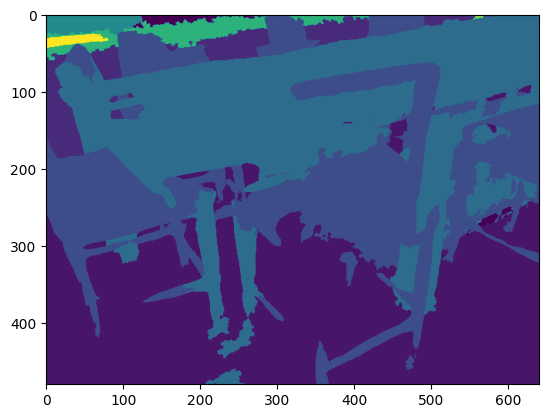

  0%|          | 0/342 [00:00<?, ?it/s]

In [53]:
import time

DATAROOT = "/scratch-shared/fsun/data/scannet/scans"
scene_id = "scene0011_00"

scene_p = osp.join(DATAROOT, scene_id)
mask_type = "ViT_masks" + "_refined"
model_name = "MVFusion_3D_small_6views"



output_dir = osp.join(scene_p, mask_type, model_name)

im_ids = os.listdir(output_dir)

im_ids = sorted(im_ids, key=lambda i: int(os.path.splitext(os.path.basename(i))[0]))

im_paths = [osp.join(output_dir, im_id) for im_id in im_ids]



for im_id in im_ids:
    im = osp.join(output_dir, im_id)
    im = Image.open(im)
    
    plt.imshow(im)
 
    plt.show()
    break
        
    

import imageio
save_dir = "/home/fsun/DeepViewAgg/notebooks/thesis_results/qualitative_results"

save_name = "test.gif"
with imageio.get_writer(osp.join(save_dir, save_name), mode='I') as writer:
    for filename in Ctq(im_paths):
        image = imageio.imread(filename)
        
        image = np.array(CLASS_COLORS)[image].astype(np.uint8)
        
        writer.append_data(image)

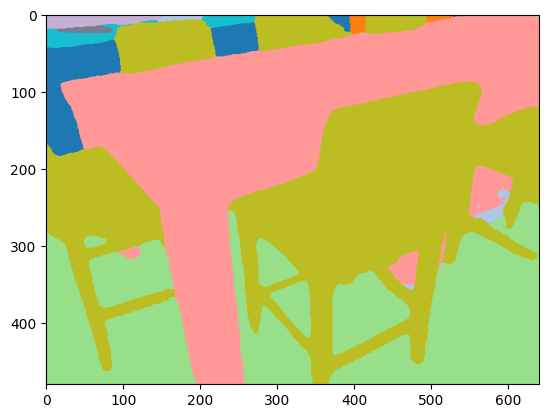

  0%|          | 0/342 [00:00<?, ?it/s]

In [61]:
import time

DATAROOT = "/home/fsun/data/scannet/scans"
scene_id = "scene0011_00"

scene_p = osp.join(DATAROOT, scene_id)
mask_type = "ViT_masks"

output_dir = osp.join(scene_p, mask_type)

im_ids = os.listdir(output_dir)

im_ids = sorted(im_ids, key=lambda i: int(os.path.splitext(os.path.basename(i))[0]))

im_paths = [osp.join(output_dir, im_id) for im_id in im_ids]



for im_id in im_ids:
    im = osp.join(output_dir, im_id)
    im = Image.open(im)
    
    im = np.array(CLASS_COLORS)[np.asarray(im) - 1].astype(np.uint8)

    
    plt.imshow(im)
 
    plt.show()
    break
        
    

import imageio
save_dir = "/home/fsun/DeepViewAgg/notebooks/thesis_results/qualitative_results"

save_name = "scene0011_00_ViT_masks.gif"
with imageio.get_writer(osp.join(save_dir, save_name), mode='I') as writer:
    for filename in Ctq(im_paths):
        image = imageio.imread(filename) - 1
        
        image = np.array(CLASS_COLORS)[image].astype(np.uint8)
        
        writer.append_data(image)

In [77]:
val_scenes = list(dataset.val_dataset.MAPPING_IDX_TO_SCAN_VAL_NAMES.values())

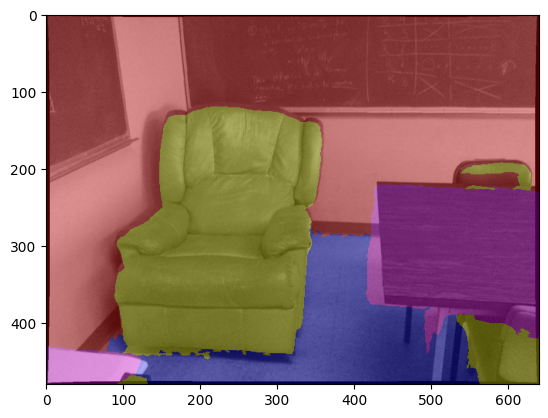

In [142]:
from skimage import color



plt.imshow(color.label2rgb(fused_mosaic, rgb_im))

[[0.68235294 0.78039216 0.90980392 0.        ]
 [0.59607843 0.8745098  0.54117647 0.        ]
 [0.12156863 0.46666667 0.70588235 0.        ]
 [1.         0.73333333 0.47058824 0.        ]
 [0.7372549  0.74117647 0.13333333 0.        ]
 [0.54901961 0.3372549  0.29411765 0.        ]
 [1.         0.59607843 0.58823529 0.        ]
 [0.83921569 0.15294118 0.15686275 0.        ]
 [0.77254902 0.69019608 0.83529412 0.        ]
 [0.58039216 0.40392157 0.74117647 0.        ]
 [0.76862745 0.61176471 0.58039216 0.        ]
 [0.09019608 0.74509804 0.81176471 0.        ]
 [0.96862745 0.71372549 0.82352941 0.        ]
 [0.85882353 0.85882353 0.55294118 0.        ]
 [1.         0.49803922 0.05490196 0.        ]
 [0.61960784 0.85490196 0.89803922 0.        ]
 [0.17254902 0.62745098 0.17254902 0.        ]
 [0.43921569 0.50196078 0.56470588 0.        ]
 [0.89019608 0.46666667 0.76078431 0.        ]
 [0.32156863 0.32941176 0.63921569 0.        ]
 [0.         0.         0.         0.        ]]
[[0.68235294

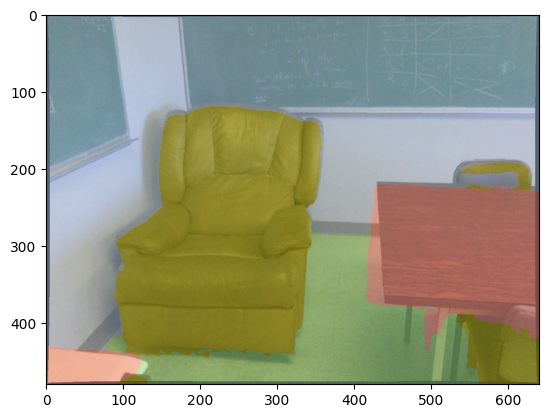

In [140]:

fused_mosaic = Image.open("/scratch-shared/fsun/data/scannet/scans/scene0030_02/ViT_masks_refined/MVFusion_3D_small_6views/0.png")
fused_mosaic = np.asarray(fused_mosaic)

rgb_im = Image.open("/scratch-shared/fsun/data/scannet/scans/scene0030_02/color_resized/0.png")
rgb_im = np.asarray(rgb_im)

## Step #1
from matplotlib import cm
import numpy as np
N = 20 # You define this here
colours = cm.get_cmap('viridis', N)  # Change the string from 'viridis' to whatever you want from the above link



cmap = np.hstack((np.array(CLASS_COLORS)/255., np.zeros((21, 1) )))

print(cmap)

cmap[:,-1] = 0.5  # Set the other alphas for the labels to be 0.3

print(cmap)
## Step #2
output = cmap[fused_mosaic.flatten()]

## Step #3
R, C = fused_mosaic.shape[:2]
output = output.reshape((R, C, -1))

## Overlay
plt.imshow(rgb_im)
plt.imshow(output)

# def return_overlayed_semantic(rgb_im, semantic_im, cmap):
    


In [101]:
import time
import imageio
    
def create_combined_gif(scene_id, mask_type, model_name, save_path, show_rgb=False):
    DATAROOT = "/scratch-shared/fsun/data/scannet/scans"
    MASKROOT = DATAROOT if mask_type == 'm2f_masks' else "/home/fsun/data/scannet/scans"

    refined_mask_type = mask_type + "_refined"

    input_dir = osp.join(MASKROOT, scene_id, mask_type)
    output_dir = osp.join(DATAROOT, scene_id, refined_mask_type, model_name)

    im_ids = os.listdir(output_dir)
    im_ids = sorted(im_ids, key=lambda i: int(os.path.splitext(os.path.basename(i))[0]))
    
    if show_rgb:
        rgb_dir = osp.join(DATAROOT, scene_id, 'color_resized')
        input_im_paths = [osp.join(rgb_dir, im_id) for im_id in im_ids]
    else:
        input_im_paths = [osp.join(input_dir, im_id) for im_id in im_ids]
    output_im_paths = [osp.join(output_dir, im_id) for im_id in im_ids]

    
    
    
    with imageio.get_writer(save_path, mode='I') as writer:
        for in_filename, out_filename in Ctq(list(zip(input_im_paths, output_im_paths))):
            in_image = imageio.imread(in_filename)
            
            if not show_rgb:
                in_image = np.array(CLASS_COLORS)[in_image - 1].astype(np.uint8)   # - 1 label correction
            
            out_image = imageio.imread(out_filename)
            out_image = np.array(CLASS_COLORS)[out_image].astype(np.uint8)
            
            combined_image = np.hstack((in_image, out_image))
            
            writer.append_data(combined_image)
            
save_dir = f"/home/fsun/DeepViewAgg/notebooks/thesis_results/qualitative_results/{scene_id}"
if not os.path.exists(save_dir):
    os.makedirs(save_dir, exist_ok=True)

save_name = f"{scene_id}_baseline_refined_comparison.gif"


index = 10
scene_id = val_scenes[index]
model_name = 'MVFusion_3D_small_6views'
mask_type = 'ViT_masks'

print("scene_id: ", scene_id)
create_combined_gif(scene_id, mask_type, model_name, osp.join(save_dir, save_name), show_rgb=True)

scene_id:  scene0030_02


  0%|          | 0/243 [00:00<?, ?it/s]

In [98]:
import util
import util_3d
from plyfile import PlyData, PlyElement
import shutil

def save_semantic_mesh(pred_file, mesh_file, output_file):
        
    if not output_file.endswith('.ply'):
        util.print_error('output file must be a .ply file')
    colors = util.create_color_palette()
    num_colors = len(colors)
    ids = util_3d.load_ids(pred_file)
    with open(mesh_file, 'rb') as f:
        plydata = PlyData.read(f)
        num_verts = plydata['vertex'].count
        if num_verts != len(ids):
            util.print_error('#predicted labels = ' + str(len(ids)) + 'vs #mesh vertices = ' + str(num_verts))
        # *_vh_clean_2.ply has colors already
        for i in range(num_verts):
            if ids[i] >= num_colors:
                util.print_error('found predicted label ' + str(ids[i]) + ' not in nyu40 label set')
            color = colors[ids[i]]
            plydata['vertex']['red'][i] = color[0]
            plydata['vertex']['green'][i] = color[1]
            plydata['vertex']['blue'][i] = color[2]
            
    plydata.write(output_file)

DATAROOT = "/scratch-shared/fsun/data/scannet/scans"
RESULTS_DIR = "/home/fsun/DeepViewAgg/notebooks/thesis_results/qualitative_results"
SEMANTIC_PRED_DIR = '/home/fsun/DeepViewAgg/notebooks/thesis_results/submission_labels'

semantic_path = osp.join(SEMANTIC_PRED_DIR, 
                         model_name, mask_type, f'{scene_id}.txt')
mesh_path = osp.join(DATAROOT, scene_id, f'{scene_id}_vh_clean_2.ply')

output_name = f'{scene_id}_semantic_mesh.ply'
output_path = osp.join(RESULTS_DIR, scene_id, output_name)

save_semantic_mesh(semantic_path,
                   mesh_path,
                   output_path)

# Baseline projection
semantic_path = osp.join(SEMANTIC_PRED_DIR, 
                         'majority_vote', mask_type, f'{scene_id}.txt')
mesh_path = osp.join(DATAROOT, scene_id, f'{scene_id}_vh_clean_2.ply')

output_name = f'{scene_id}_semantic_mesh_baseline_projection.ply'
output_path = osp.join(RESULTS_DIR, scene_id, output_name)

save_semantic_mesh(semantic_path,
                   mesh_path,
                   output_path)

# Copy semantic mesh to output folder
# shutil.copyfile(mesh_path, osp.join(RESULTS_DIR, scene_id, f'{scene_id}_mesh.ply'))

'/home/fsun/DeepViewAgg/notebooks/thesis_results/qualitative_results/scene0030_02/scene0030_02_mesh.ply'

# 3DU inference and visualization

In [82]:
from torch_points3d.datasets.segmentation.multimodal.scannet_inference import ScannetDatasetMM_Inference



### Note: set over to Python file with argparse from script file
MASK_NAME = 'ViT_masks'


# # DeepSet - DeepSetAttention (check model/config correctness)
# checkpoint_dir = '/home/fsun/DeepViewAgg/outputs/2023-02-11/10-52-09'   # ViT_masks
# # checkpoint_dir = '/home/fsun/DeepViewAgg/outputs/2023-02-11/10-54-19'   # m2f_masks
# dataset_config = 'segmentation/multimodal/Feng/inference.yaml'   
# models_config = 'segmentation/multimodal/Feng/view_selection_experiment'    # model family
# model_name = 'DeepSetAttention'                       # specific model

# Deepset_3D
models_config = 'segmentation/multimodal/Feng/view_selection_experiment'
checkpoint_dir = '/home/fsun/DeepViewAgg/outputs/2023-02-21/17-48-02'
dataset_config = 'segmentation/multimodal/Feng/inference.yaml'   
model_name = 'Deepset_3D'                       # specific model


# # # Transformer - MVFusion_orig
# checkpoint_dir = '/home/fsun/DeepViewAgg/outputs/MVFusion_orig'   # ViT_masks
# # checkpoint_dir = '/home/fsun/DeepViewAgg_31-10-22/DeepViewAgg/outputs/2023-02-11/22-17-12'   # m2f_masks
# dataset_config = 'segmentation/multimodal/Feng/scannet-neucon-smallres-m2f-allviews.yaml'   
# models_config = 'segmentation/multimodal/Feng/mvfusion_orig'    # model family
# model_name = 'MVFusion_orig'                       # specific model

overrides = [
    'task=segmentation',
    f'data={dataset_config}',
    f'data.dataroot=/home/fsun/data/inference_data/dva_processed',
    f'models={models_config}',
    f'model_name={model_name}',
]

cfg = hydra_read(overrides)
OmegaConf.set_struct(cfg, False)  # This allows getattr and hasattr methods to function correctly
cfg.data.load_m2f_masks = True   # load input masks
cfg.data.m2f_preds_dirname = MASK_NAME
cfg.data.n_views = cfg.models[model_name].backbone.transformer.n_views
print(cfg.data.n_views)

# Dataset instantiation
dataset = ScannetDatasetMM_Inference(cfg.data)


6
Load predicted 2D semantic segmentation labels from directory  ViT_masks
initialize test dataset
line 720 scannet.py: split == 'test'


In [86]:
from torch_points3d.models.model_factory import instantiate_model

# Set your parameters
# checkpoint_dir = '/home/fsun/DeepViewAgg/outputs/2022-12-07/12-07-34' # 3rd run
# checkpoint_dir = '/home/fsun/DeepViewAgg/outputs/ViT_masks_3rd_run'

# Create the model
print(f"Creating model: {cfg.model_name}")
model = instantiate_model(cfg, dataset)

# Load the checkpoint and recover the model weights
checkpoint = torch.load(f'{checkpoint_dir}/{model_name}.pt', map_location='cpu')
model.load_state_dict_with_same_shape(checkpoint['models']['latest'], strict=False)

# Prepare the model for inference
model = model.eval().cuda()
print('Model loaded')

Creating model: Deepset_3D
task:  segmentation.multimodal
tested_model_name:  Deepset_3D
Manually set number of classes for model initialization in DeepViewAgg/torch_points3d/datasets/base_dataset.py, line 471
Manually set number of classes for model initialization in DeepViewAgg/torch_points3d/datasets/base_dataset.py, line 471
class_name:  MVAttentionAPIModel
model_module:  torch_points3d.models.segmentation.multimodal.Feng.mvattention_attention_weighted_m2f_pred
name, cls of chosen model_cls:  MVAttentionAPIModel <class 'torch_points3d.models.segmentation.multimodal.Feng.mvattention_attention_weighted_m2f_pred.MVAttentionAPIModel'>
Manually set number of classes for model initialization in DeepViewAgg/torch_points3d/datasets/base_dataset.py, line 471
x feature dim:  {'FEAT': 3}
nc_in:  35
nc_in:  64
nc_in:  32
nc_in:  64
nc_in:  128
Enabling checkpointing for:  
nc_in:  256
nc_in:  128
nc_in:  128
nc_in:  96
nc_in:  96
Manually set number of classes for model initialization in DeepV

In [139]:
mm_data = dataset.test_dataset[0][0]

In [140]:
mm_data

MMData(
    data = Data(coords=[126170, 3], grid_size=[1], id_scan=[1], mapping_index=[126170], mvfusion_input=[100407, 6, 10], norm=[126170, 3], origin_id=[126170], pos=[126170, 3], rgb=[126170, 3], x=[126170, 3])
    image = ImageData(num_settings=1, num_views=128, num_points=126170, device=cpu)
)

In [141]:
with torch.no_grad():
    # Create a MMBatch and run inference
    batch = MMBatch.from_mm_data_list([mm_data])
#     batch = get_seen_points(batch)

    model.set_input(batch, model.device)
    model.forward(epoch=1)

    # Recover the predicted labels for visualization
    mm_data.data.pred = model.output.detach().cpu().argmax(1)
        
    batch = get_seen_points(batch)
    mode_pred = get_mode_pred(batch)
    

In [90]:
visualize_mm_data(mm_data, figsize=1000, pointsize=3, voxel=0.05, show_2d=False, back='m2f_pred_mask', front='x', class_names=CLASS_NAMES, class_colors=CLASS_COLORS, alpha=0.3)

In [142]:
visualize_mm_data(mm_data, figsize=1000, pointsize=3, voxel=0.05, show_2d=False, back='m2f_pred_mask', front='x', class_names=CLASS_NAMES, class_colors=CLASS_COLORS, alpha=0.3)

In [175]:
# seen_data = get_seen_points(mm_data)
# seen_data.data.pred = mode_pred
# visualize_mm_data(seen_data, figsize=1000, pointsize=3, voxel=0.05, show_2d=False, back='m2f_pred_mask', front='x', class_names=CLASS_NAMES, class_colors=CLASS_COLORS, alpha=0.3)

In [174]:
import time
import imageio
    
def create_combined_gif(scene_id, mask_type, model_name, save_path, show_rgb=False):
    DATAROOT = "/home/fsun/data/inference_data/dva_processed/rot270/raw/scans_test"
    MASKROOT = DATAROOT

    refined_mask_type = mask_type #+ "_refined"

    input_dir = osp.join(MASKROOT, scene_id, mask_type)
    output_dir = osp.join(DATAROOT, scene_id, refined_mask_type)#, model_name)

    im_ids = os.listdir(input_dir)
    im_ids = sorted(im_ids, key=lambda i: int(os.path.splitext(os.path.basename(i))[0]))
    
    if show_rgb:
        rgb_dir = osp.join(DATAROOT, scene_id, 'color_rotated')
        input_im_paths = [osp.join(rgb_dir, im_id) for im_id in im_ids]
    else:
        input_im_paths = [osp.join(input_dir, im_id) for im_id in im_ids]
    
    output_im_paths = [osp.join(output_dir, im_id) for im_id in im_ids]

    print(len(input_im_paths))
    
    with imageio.get_writer(save_path, mode='I') as writer:
        for in_filename, out_filename in Ctq(list(zip(input_im_paths, output_im_paths))):
            in_image = imageio.imread(in_filename)
            
            if not show_rgb:
                in_image = np.array(CLASS_COLORS)[in_image - 1].astype(np.uint8)   # - 1 label correction
            
            out_image = imageio.imread(out_filename)
            out_image = np.array(CLASS_COLORS)[out_image  - 1].astype(np.uint8) # - 1 label correction
            
            out_image = np.rot90(out_image, k=3)
            
            combined_image = np.hstack((in_image, out_image))
            
            writer.append_data(combined_image)
            
            
scene_id = 'see_current_morning_724'
save_dir = f"/home/fsun/DeepViewAgg/notebooks/thesis_results/qualitative_results/{scene_id}"
if not os.path.exists(save_dir):
    os.makedirs(save_dir, exist_ok=True)

save_name = f"{scene_id}_rgb.gif"

model_name = 'None'
mask_type = 'ViT_masks'

print("scene_id: ", scene_id)
create_combined_gif(scene_id, mask_type, model_name, osp.join(save_dir, save_name), show_rgb=True)

scene_id:  see_current_morning_724
128


  0%|          | 0/128 [00:00<?, ?it/s]

In [143]:
mm_data
import struct
from plyfile import PlyData, PlyElement

# def write_pointcloud(filename,xyz_points,rgb_points=None):

#     """ creates a .pkl file of the point clouds generated
#     """

#     assert xyz_points.shape[1] == 3,'Input XYZ points should be Nx3 float array'
#     if rgb_points is None:
#         rgb_points = np.ones(xyz_points.shape).astype(np.uint8)*255
#     assert xyz_points.shape == rgb_points.shape,'Input RGB colors should be Nx3 float array and have same size as input XYZ points'

#     # Write header of .ply file
#     fid = open(filename,'wb')
#     fid.write(bytes('ply\n', 'utf-8'))
#     fid.write(bytes('format binary_little_endian 1.0\n', 'utf-8'))
#     fid.write(bytes('element vertex %d\n'%xyz_points.shape[0], 'utf-8'))
#     fid.write(bytes('property float x\n', 'utf-8'))
#     fid.write(bytes('property float y\n', 'utf-8'))
#     fid.write(bytes('property float z\n', 'utf-8'))
#     fid.write(bytes('property uchar red\n', 'utf-8'))
#     fid.write(bytes('property uchar green\n', 'utf-8'))
#     fid.write(bytes('property uchar blue\n', 'utf-8'))
#     fid.write(bytes('end_header\n', 'utf-8'))

#     # Write 3D points to .ply file
#     for i in range(xyz_points.shape[0]):
#         fid.write(bytearray(struct.pack("fffccc",xyz_points[i,0],xyz_points[i,1],xyz_points[i,2],
#                                         rgb_points[i,0].tostring(),rgb_points[i,1].tostring(),
#                                         rgb_points[i,2].tostring())))
#     fid.close()

    
def to_ply(pos, norm, label, file):
    assert len(label.shape) == 1
    assert pos.shape[0] == label.shape[0]
    assert pos.shape[0] == norm.shape[0]

    pos = np.asarray(pos)
    norm = np.asarray(norm)

    colors = np.array(CLASS_COLORS)[np.asarray(label).astype(np.uint8)].astype(np.uint8)
    
    ply_array = np.ones(
        pos.shape[0], dtype=[("x", "f4"), ("y", "f4"), ("z", "f4"), ("nx", "f4"), ("ny", "f4"), ("nz", "f4"), 
                             ("red", "u1"), ("green", "u1"), ("blue", "u1")]
    )
    
    ply_array["x"] = pos[:, 0]
    ply_array["y"] = pos[:, 1]
    ply_array["z"] = pos[:, 2]
    ply_array["nx"] = norm[:, 0]
    ply_array["ny"] = norm[:, 1]
    ply_array["nz"] = norm[:, 2]
    ply_array["red"] = colors[:, 0]
    ply_array["green"] = colors[:, 1]
    ply_array["blue"] = colors[:, 2]
    el = PlyElement.describe(ply_array, "vertex")
    PlyData([el], byte_order=">").write(file)
    print(PlyData([el], byte_order=">"))
    
# xyz = mm_data.pos.numpy()
# rgb = np.array(CLASS_COLORS)[mm_data.data.pred.numpy().astype(np.uint8)].astype(np.uint8)

scene_dir = "/home/fsun/DeepViewAgg/notebooks/thesis_results/qualitative_results/see_current_morning_724"
to_ply(mm_data.pos, mm_data.data.norm, mm_data.data.pred, osp.join(scene_dir, "see_current_morning_724_semantic_0.04voxel.ply"))
# to_ply(m2f_mm_data.pos, m2f_mm_data.data.pred, "2d_projected_prediction.ply")

ply
format binary_big_endian 1.0
element vertex 126170
property float x
property float y
property float z
property float nx
property float ny
property float nz
property uchar red
property uchar green
property uchar blue
end_header


In [100]:
a = sorted(list(mm_data.data.norm.sum(axis=1)))
a[-5:]

[tensor(1.7316),
 tensor(1.7317),
 tensor(1.7318),
 tensor(1.7319),
 tensor(1.7319)]

# Inference semantic pcd to mesh

tensor([  0,   0,   0,  ..., 127, 127, 127])
['/home/fsun/data/inference_data/dva_processed/rot270/raw/scans_test/see_current_morning_724/sens/color/30.png']


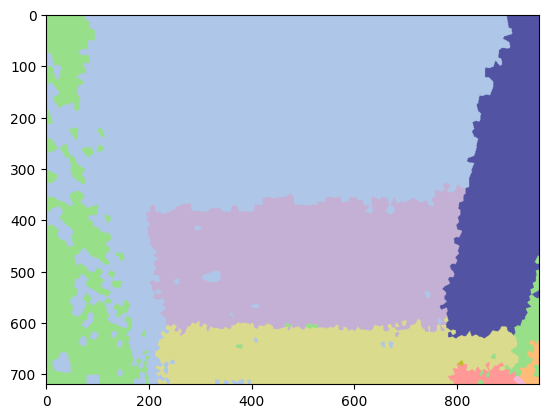

['/home/fsun/data/inference_data/dva_processed/rot270/raw/scans_test/see_current_morning_724/sens/color/1120.png']


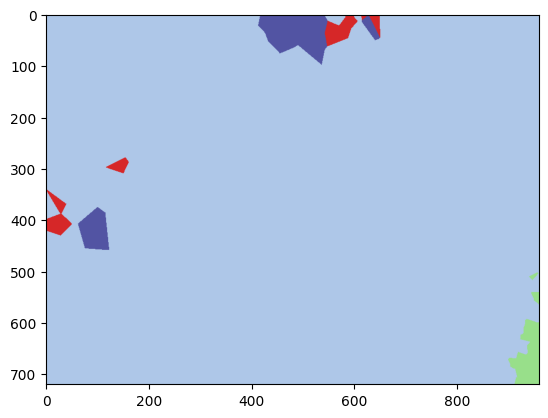

['/home/fsun/data/inference_data/dva_processed/rot270/raw/scans_test/see_current_morning_724/sens/color/960.png']


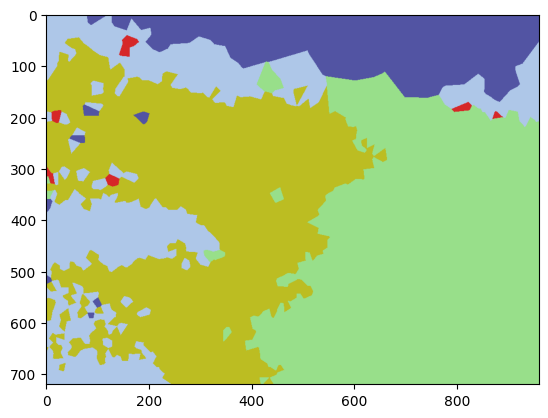

['/home/fsun/data/inference_data/dva_processed/rot270/raw/scans_test/see_current_morning_724/sens/color/1200.png']


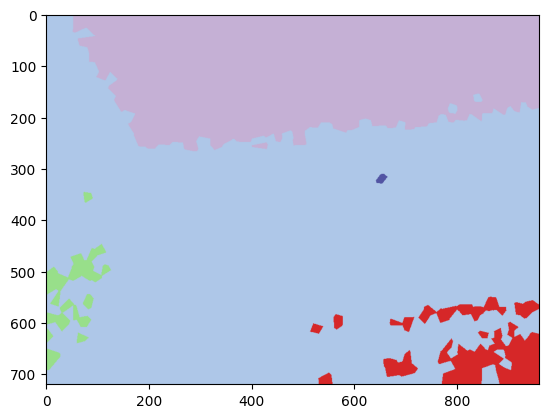

['/home/fsun/data/inference_data/dva_processed/rot270/raw/scans_test/see_current_morning_724/sens/color/610.png']


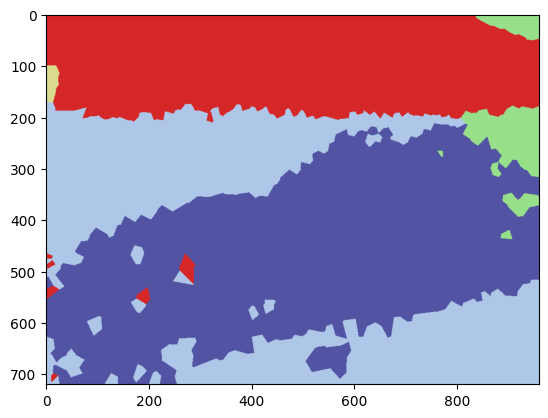

['/home/fsun/data/inference_data/dva_processed/rot270/raw/scans_test/see_current_morning_724/sens/color/160.png']


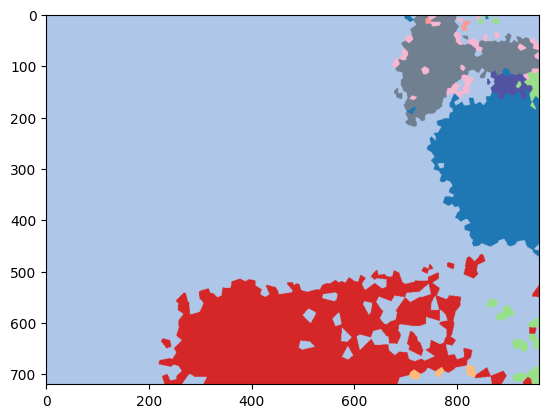

['/home/fsun/data/inference_data/dva_processed/rot270/raw/scans_test/see_current_morning_724/sens/color/10.png']


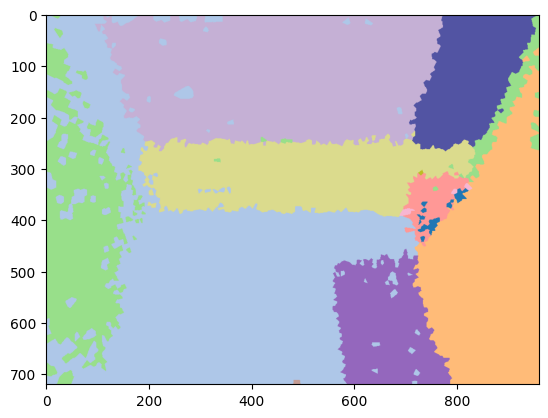

['/home/fsun/data/inference_data/dva_processed/rot270/raw/scans_test/see_current_morning_724/sens/color/810.png']


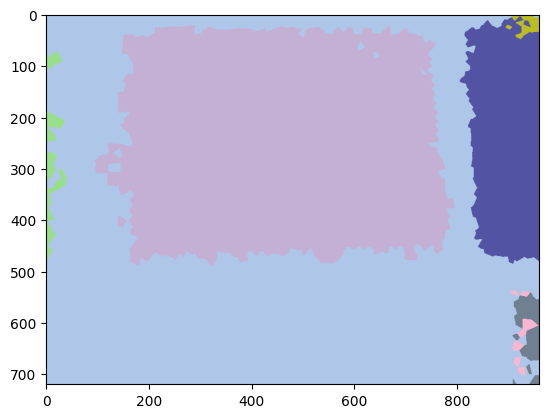

['/home/fsun/data/inference_data/dva_processed/rot270/raw/scans_test/see_current_morning_724/sens/color/1070.png']


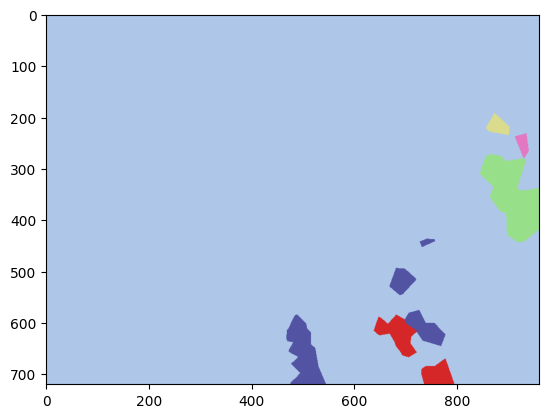

['/home/fsun/data/inference_data/dva_processed/rot270/raw/scans_test/see_current_morning_724/sens/color/690.png']


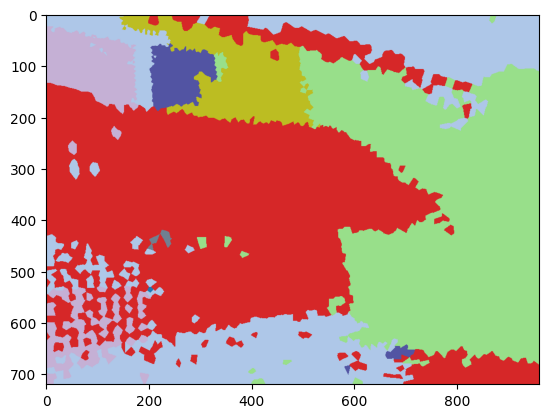

['/home/fsun/data/inference_data/dva_processed/rot270/raw/scans_test/see_current_morning_724/sens/color/360.png']


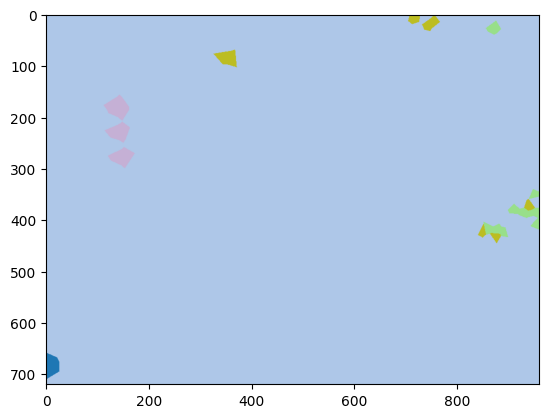

['/home/fsun/data/inference_data/dva_processed/rot270/raw/scans_test/see_current_morning_724/sens/color/900.png']


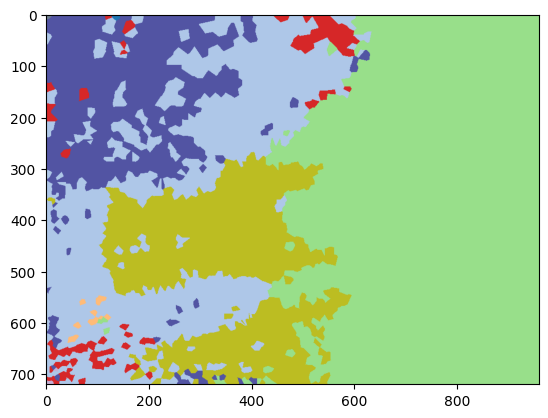

['/home/fsun/data/inference_data/dva_processed/rot270/raw/scans_test/see_current_morning_724/sens/color/760.png']


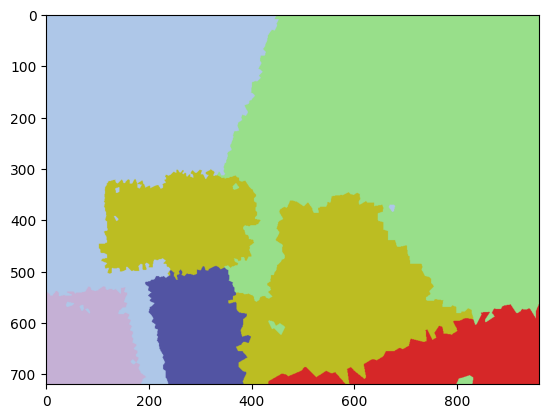

['/home/fsun/data/inference_data/dva_processed/rot270/raw/scans_test/see_current_morning_724/sens/color/50.png']


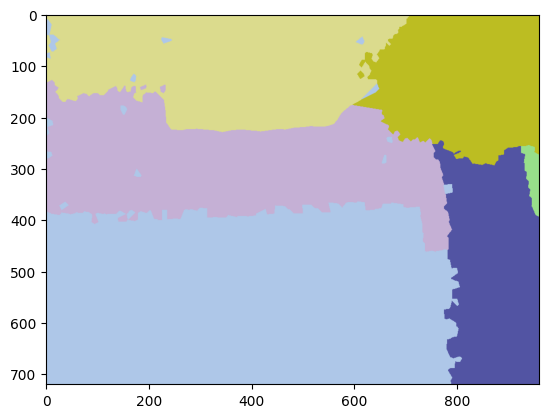

['/home/fsun/data/inference_data/dva_processed/rot270/raw/scans_test/see_current_morning_724/sens/color/180.png']


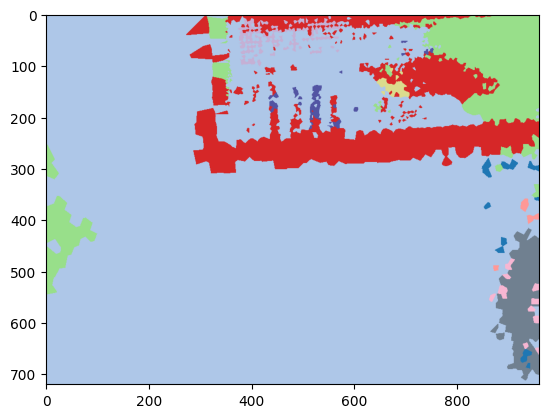

['/home/fsun/data/inference_data/dva_processed/rot270/raw/scans_test/see_current_morning_724/sens/color/1050.png']


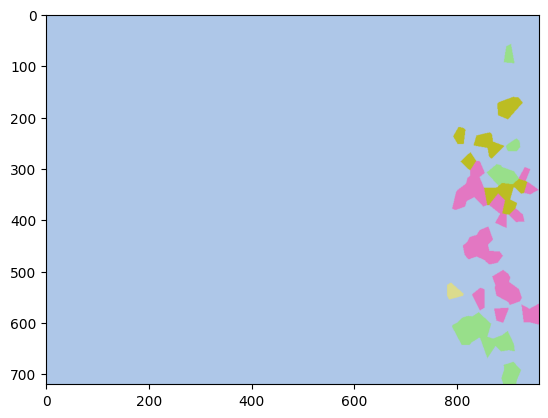

['/home/fsun/data/inference_data/dva_processed/rot270/raw/scans_test/see_current_morning_724/sens/color/630.png']


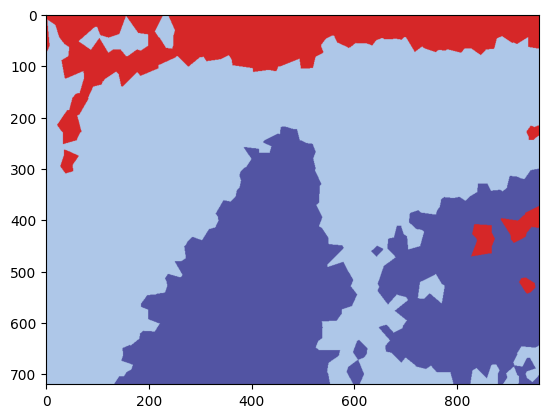

['/home/fsun/data/inference_data/dva_processed/rot270/raw/scans_test/see_current_morning_724/sens/color/860.png']


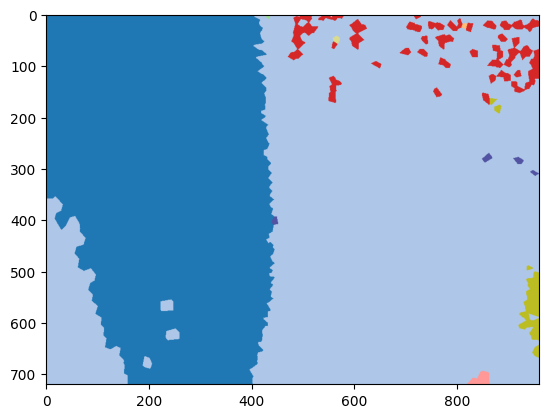

['/home/fsun/data/inference_data/dva_processed/rot270/raw/scans_test/see_current_morning_724/sens/color/1150.png']


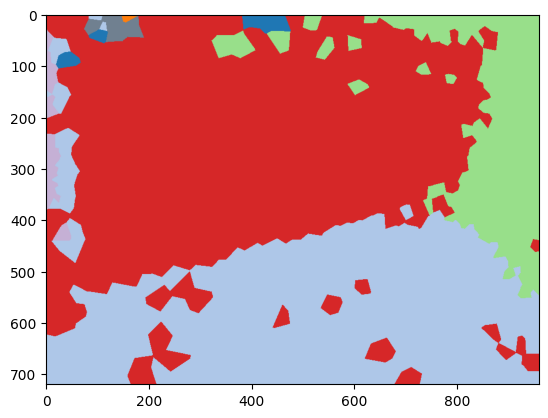

['/home/fsun/data/inference_data/dva_processed/rot270/raw/scans_test/see_current_morning_724/sens/color/490.png']


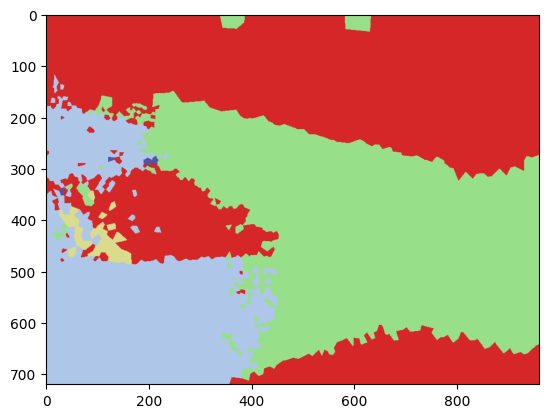

['/home/fsun/data/inference_data/dva_processed/rot270/raw/scans_test/see_current_morning_724/sens/color/350.png']


KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

In [23]:
from torch_points3d.utils.multimodal import lexargsort
from torch_points3d.core.multimodal.csr import CSRData
import scipy.ndimage

mappings = mm_data.modalities['image'][0].mappings
point_ids = torch.arange(
                mappings.num_groups, device=mappings.device).repeat_interleave(
                mappings.pointers[1:] - mappings.pointers[:-1])
image_ids = mappings.images.repeat_interleave(
                mappings.values[1].pointers[1:] - mappings.values[1].pointers[:-1])    
pixels_full = mappings.pixels

# Sort point and image ids based on image_id
idx_sort = lexargsort(image_ids, point_ids)
image_ids = image_ids[idx_sort]
point_ids = point_ids[idx_sort]
pixels_full = pixels_full[idx_sort].long()

print(image_ids)

# Get pointers for easy indexing
pointers = CSRData._sorted_indices_to_pointers(image_ids)

# Loop over all N views
for i, x in enumerate(mm_data.modalities['image'][0]):
    
    print(x.path)

    # Grab the 3D points corresponding to ith view
    start, end = pointers[i], pointers[i+1]    
    points = point_ids[start:end]
    pixels = pixels_full[start:end]
    # Image (x, y) pixel index
    w, h = pixels[:, 0], pixels[:, 1]

    # Grab set of points visible in current view
    mm_data_of_view = mm_data[points]

    im_ref_w, im_ref_h = x.ref_size

    # Get nearest neighbor interpolated projection image filled with 3D labels
    pred_mask_2d = -1 * torch.ones((im_ref_h, im_ref_w), dtype=torch.long, device=mm_data_of_view.device)    
    pred_mask_2d[h, w] = mm_data_of_view.data.pred.squeeze()

    nearest_neighbor = scipy.ndimage.morphology.distance_transform_edt(
        pred_mask_2d==-1, return_distances=False, return_indices=True)    
    pred_mask_2d = pred_mask_2d[nearest_neighbor].numpy().astype(np.uint8)
    pred_mask_2d = Image.fromarray(pred_mask_2d, 'L')       
    
    pred_mask_2d = np.array(CLASS_COLORS)[pred_mask_2d].astype(np.uint8)
    plt.imshow(pred_mask_2d)
    
    plt.show()
    
    break
    


In [38]:
import open3d as o3d
# import open3d_tutorial as o3dtut


pcd = o3d.io.read_point_cloud("/home/fsun/data/inference_data/dva_processed/rot270/raw/scans_test/see_current_morning_724/see_current_morning_724.ply")
print(pcd)

# pcd = mesh.sample_points_poisson_disk(750)
# o3d.visualization.draw_geometries([pcd])
# alpha = 0.03
# print(f"alpha={alpha:.3f}")
# mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_alpha_shape(pcd, alpha)
# mesh.compute_vertex_normals()
# o3d.visualization.draw_geometries([mesh], mesh_show_back_face=True)

PointCloud with 142543 points.


In [115]:
radii = [0.06]
rec_mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(
    pcd, o3d.utility.DoubleVector(radii))
# o3d.visualization.draw_geometries([pcd, rec_mesh])
rec_mesh

TriangleMesh with 142543 points and 96810 triangles.

In [116]:
os.getcwd()
scene_id = "see_current_morning_724"
o3d.io.write_triangle_mesh(osp.join(scene_dir, "test.ply"), rec_mesh)

True

In [3]:
semantic_mesh = o3d.io.read_triangle_mesh(osp.join(scene_dir, 'see_current_morning_724_semantic_0.04voxel_meshed.ply'))
semantic_mesh

NameError: name 'o3d' is not defined

# Debug why raycasting fails (mesh or camera error)

In [57]:
scene_id = "see_current_morning_724"
scans_dir = "/home/fsun/data/inference_data/dva_processed/rot270/raw/scans_test/"
scene_dir = osp.join(scans_dir, scene_id)
mesh_path = osp.join(scene_dir, 'see_current_morning_724_semantic_0.04voxel_meshed.ply')
print(mesh_path)
preprocessed_2d_data_dir = "/home/fsun/data/inference_data/dva_processed/rot270/processed/processed_2d_test"
scale = 1.0
output_image_size = (int(720*scale), int(960*scale))

# scene_id = "scene0011_00"
# scans_dir = "/scratch-shared/fsun/data/scannet/scans"
# scene_dir = osp.join(scans_dir, scene_id)
# mesh_path = osp.join('/scratch-shared/fsun/data/scannet/scans/scene0011_00/scene0011_00_vh_clean_2.ply')
# preprocessed_2d_data_dir = "/scratch-shared/fsun/dvata/scannet-neucon-smallres-m2f/processed/processed_2d_val"
# output_image_size = (480, 640)

/home/fsun/data/inference_data/dva_processed/rot270/raw/scans_test/see_current_morning_724/see_current_morning_724_semantic_0.04voxel_meshed.ply


Cannot find axis align matrix
contained_mesh_triangles:  (651029, 3)
122294
SizeVector[126170, 3]
face_colors:  SizeVector[651029, 3]
face_colors[0]  [0.682353 0.780392 0.909804]
Tensor[shape={3}, stride={1}, Float32, CPU:0, 0x555ec288ea80]


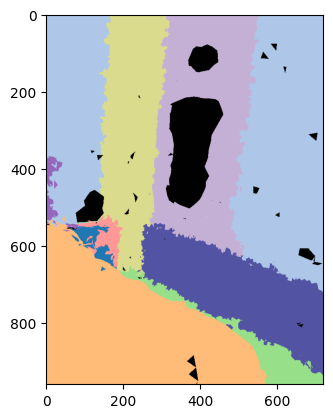

TypeError: Cannot handle this data type: (1, 1, 3), <i8

In [91]:
import open3d as o3d

def get_semantic_image_from_camera(scene, mesh, mesh_triangles, intrinsic, extrinsic, class_id_faces, im_size=(480, 640)):
    """
    Returns the back-projected semantic label image given camera parameters and (semantic) mesh.
    """

    # Recover intrinsic error for 3DU data
    if intrinsic[-1, -1] == 0.:
        intrinsic[-1, -1] = 1.
    
    # Initialize rays for given camera
    rays = o3d.t.geometry.RaycastingScene.create_rays_pinhole(
        intrinsic_matrix=intrinsic,
        extrinsic_matrix=extrinsic,
        width_px=im_size[1],
        height_px=im_size[0],
    )
        
    

    # Get result
    ans = scene.cast_rays(rays)

    primitive_ids = ans['primitive_ids'].numpy()
    primitive_uvs = ans['primitive_uvs'].numpy()
    

    # Select the closest vertex for each valid face in the projected mesh
    valid_mask = primitive_ids != scene.INVALID_ID

    # https://stackoverflow.com/questions/45212949/vertex-of-a-3d-triangle-that-is-closest-to-a-point-given-barycentric-parameter-o
    w_coords = (1 - primitive_uvs[:, :, 0][valid_mask] - primitive_uvs[:, :, 1][valid_mask])
    barycentric_coords = np.concatenate((w_coords[:, None], primitive_uvs[valid_mask]), axis=-1)

    selected_vertex_idx = np.argmax(barycentric_coords, axis=-1)

    contained_mesh_triangles = mesh_triangles[primitive_ids[valid_mask]]
    closest_mesh_vertices = contained_mesh_triangles[range(len(barycentric_coords)), selected_vertex_idx]
    
    print("contained_mesh_triangles: ", contained_mesh_triangles.shape)


    print(closest_mesh_vertices.max())
    print(mesh.vertex.colors.shape)
    
    # Map faces to face colors based on its closest mesh vertex 
    face_colors = mesh.vertex.colors[closest_mesh_vertices]
    print("face_colors: ", face_colors.shape)
    print("face_colors[0] ", face_colors[0])
        

    
    # Visualize back-projection
    image = torch.ones((im_size[0], im_size[1], 3), dtype=torch.long) # * -1
    image[valid_mask] = torch.tensor(face_colors.numpy()*255).to(torch.long)
    
    return image
    

    # NN interpolation at invalid pixels          
    nearest_neighbor = scipy.ndimage.morphology.distance_transform_edt(
        image==-1, return_distances=False, return_indices=True)    

    image = image[nearest_neighbor].numpy()
    return image


def mesh_to_image(cfg, mesh_path, scans_dir, scene_id, preprocessed_2d_data_dir, output_image_size=(480, 640),
                  save_output='if_not_exists'):
    # User input
    ########################################################################################################################
    input_mask_name = 'ViT_masks'


#     for scan_name in Ctq(scan_names):
    # Output folder location
    refined_mask_dir = osp.join(scans_dir, scene_id, f"{input_mask_name}_refined", f"{cfg.model_name}")

    if not osp.exists(refined_mask_dir):
        os.makedirs(refined_mask_dir)


    # Load data
    mesh = o3d.io.read_triangle_mesh(mesh_path)
    mesh_triangles = np.asarray(mesh.triangles)
    mesh = o3d.t.geometry.TriangleMesh.from_legacy(mesh)


    # Camera parameters
    intrinsic = np.loadtxt(f"{scans_dir}/{scene_id}/sens/intrinsic/intrinsic_depth.txt")[:3, :3]
    images = torch.load(f"{preprocessed_2d_data_dir}/{scene_id}.pt")


    # Undo axis alignment for extrinsics  
    axis_align_matrix_path = osp.join(scans_dir, scene_id, scene_id + '.txt')
    axis_align_matrix = read_axis_align_matrix(axis_align_matrix_path)

    if axis_align_matrix is not None:
        inv = torch.linalg.inv(axis_align_matrix.T)
        images.extrinsic = inv.T  @ images.extrinsic        

    # Make world-to-camera
    extrinsics = torch.linalg.inv(images.extrinsic).numpy()
    image_names = [osp.splitext(osp.basename(x))[0] for x in images.path]

    # Raycasting
    scene = o3d.t.geometry.RaycastingScene()
    scene.add_triangles(mesh)

    count = 0
    for i in range(len(image_names)):
        image = get_semantic_image_from_camera(scene=scene, mesh=mesh, mesh_triangles=mesh_triangles, intrinsic=intrinsic,
                                               extrinsic=extrinsics[i], 
                                               class_id_faces=None, im_size=output_image_size)
        plt.imshow(np.rot90(image, k=3))
        plt.show()

        count += 1


        # Save refined prediction (backprojected from mesh + interpolated missing pixels)
        image =  image.numpy()

        image = Image.fromarray(image)
        im_save_path = osp.join(refined_mask_dir, image_names[i] + '.png')
        image.save(im_save_path)   
        
        if count > 0:
            return

image = mesh_to_image(cfg, mesh_path, scans_dir, scene_id, preprocessed_2d_data_dir, output_image_size, save_output='if_not_exists')

In [62]:
import matplotlib.pyplot as plt

mesh

NameError: name 'mesh' is not defined

In [12]:
image

array([[[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]],

       ...,

       [[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]]], dtype=float32)